<img src="header2.png">

## About This IPython Process Book

Welcome! Below you will find our IPython process book for our AC209 (Data Science) final project at Harvard University. This process book details our steps in developing our solution: the data collection process we used, the statistical methods we applied, and the insights we found. Specifically, this process book follows the following outline:


1. <a href='#overview'><strong>Overview and Motivation</strong></a>

2. <a href='#related'><strong>Related Work</strong></a>

3. <a href='#questions'><strong>Initial Questions</strong></a>

4. <a href='#data'><strong>The Data</strong></a>

5. <a href='#exploratory'><strong>Exploratory Data Analysis</strong></a>

6. <a href='#final'><strong>Final Analysis</strong></a>

7. <a href='#conclusion'><strong>Conclusion</strong></a>


<a id='overview'></a>
## Overview and Motivation


![New York Times Logo](NewYorkTimes_Logo.jpg)



As one of the most popular online news entities, The New York Times (NYT) [attracts thousands](http://www.journalism.org/media-indicators/digital-top-50-online-news-entities-2015/) of unique visitors each day to its website, [nytimes.com](http://www.nytimes.com). Users who visit the site can provide their thoughts and reactions to published content in the form of comments. 

The website receives around 9,000 submitted comments per day, over 60,000 unique contributors per month, and approximately two million comment recommendations (i.e., "likes") [each month](http://www.nytimes.com/2015/11/23/insider/the-most-popular-reader-comments-on-the-times.html). There is a dedicated staff commited to review each submission and even hand-select the very best comments as "NYT Picks."

<img src="NYT Pick ex.png" width="600">

The Times embraces this personal, intimate approach to comment moderation based on the hypothesis that "readers of The Times would demand an elevated experience." Thus, we aim to examine the relationship between comment success (i.e., the number of recommendations it receives by other users and if it is selected as a NYT Pick) and  various features of the  comment itself. This way, we will be able to produce a model that can predict the success of a given comment. 

We envision this model as a complementary tool used in the moderators' daily review of each comment. Perhaps there is a comment they are unsure about; they could run our model to see the comment's predicted success.

This tool could also benefit the commenters themselves. An effective prediction system could be used in an automated comment recommender to help steer users toward higher quality content.

<a id='related'></a>
## Related Work

We are all avid readers of The New York Times and find the comment section to be a great launching pad for further discussion and debate. Moreover, Andrew was on the leadership board of The Harvard Crimson, so he has experienced journalism first-hand.

While we have not encountered any work that specifically looks at what makes a successful comment on a news site such as that of the NYT, there has been some recent analysis by the NYT on their top 14 commenters. Their methodology to select the top 14 was to divide Total No. of Recommendations by Total No. of Comments and add a small bonus for each "NYT Pick" designation. The feature on the top 14 commenters themselves can be found [here](http://www.nytimes.com/interactive/2015/11/23/nytnow/23commenters.html?_r=0), and the description about the methodology can be found [here](http://www.nytimes.com/2015/11/23/insider/the-most-popular-reader-comments-on-the-times.html).



<img src="Top Commenters.png" width="600">



#### Sentiment Analysis

In our project, we will employ sentiment analysis. Below are summaries of some interesting past work using sentiment analysis.

[Agarwal et al.](http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf) focused on the sentiment analysis of Twitter data. Specifically they built models for classifying tweets into positive, negative, and neutral sentiment. To do so, three separate models were used. In their work, they found that standard natural languge processing tools are useful even in a genre which is quite different from the genre on which they were trained.  

[Pang et al.](http://www.cs.cornell.edu/home/llee/papers/cutsent.pdf) also invsetigate sentiment analysis but propose a new machine-learning method that applies categorization techniques to only the subjective portions of the input document. Specifically, their process is as follows: they label sentences as either subjective or objective, discarding the objective sentences as they go. Then they apply a machine learning classifier. They show that subjectivity alone can accurately represent the sentiment information.

<a id='questions'></a>
## Initial Questions

We approached this project with following two main questions in mind:

   * Can we predict how many recommendations a comment will receive? 
   
   
   * Can we predict if a comment will be selected as a NYT Pick?

Additionally, we aim to quantitatively examine what makes a successful and highly rated comment. For example, do longer comments fare better? Does average word or sentence length play a role? Does the sentiment of the comment have an effect?



<a id='data'></a>
## The Data

We obtained the comment data from The New York Times [API](http://developer.nytimes.com/docs). The API operates similarly to that of the Huffington Post API that was used earlier in the course. Initially, we planned to gather 300 comments per day (i.e., 12 requests per day and 25 comments per request) from Nov 1, 2014 to Nov 15, 2015. However, we ran into issues caused by the API frequently that unpredictably returned a link to the [New York Times generic error page](http://www.nytimes.com/content/help/error.html) Note that this returns an HTTP response code of 200 (OK), in contrast to errors resulting from exceeding rate limits or server errors, which return 400, 404, or 500 response codes. Often, trying a specific query again would succeed, but, for several dates, we found ourselves totally unable to extract any comments at all.

The code below is highly robust against these sorts of errors. For each search, it tries four times to get a valid response, with short waits in between each try. Failing that, it moves on to the next date in the range, dumping that day's comments if any are found, into a file. This ensures that if the script crashes during execution, it will lose at most one day's worth of results. This produces one JSON file for each day, so we then combine all these files into one large file. Finally, we put all the comments into a data frame.

In [1]:
# Import packages, libraries, and modules to be used

from datetime import date, datetime, timedelta
import requests, time, simplejson, sys, re
import numpy as np
import pandas as pd
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from scipy.sparse import csr_matrix as csr
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set_style("darkgrid")
%matplotlib inline

### Scraping

In [2]:
# Yields an iterator which allows to iterate through date.
# This function draws from http://stackoverflow.com/a/10688060

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [ ]:
# Scrape 300 comments per day
# For each search, loop tries 4 times to get a valid response. 
# If >4 tries, then loops moves on to next day, dumping that day's comments if any are found into a file. 
# Outputs a JSON file for each day.

for da in perdelta(date(2015, 2, 21), date(2015, 11, 1), timedelta(days=1)):
    comments = []
    print da
    skip = False
    gotany = True
    
    # Collect 25 comments at a time for 12 times (25*12 = 300 comments)
    for i in range(12): 
        if not skip:
            success = False
            count = 0
            
            # Need to include your own API key here
            url = ('http://api.nytimes.com/svc/community/v3/user-content/' +
                   'by-date.json?api-key=KEY&date=' + str(da) +
                   '&offset=' + str(25*i))
            
            while not success:
                comments_data = requests.get(url)
                try:
                    data = simplejson.loads(comments_data.content)
                    success = True # go to the next offset
                    for d in data['results']['comments']:
                        comments.append(d)
                    time.sleep(2)
                except:
                    print 'error on {}'.format(str(da))
                    print url
                    count += 1
                    if count > 3:
                        success = True 
                        #skip to the next day
                        skip = True 
                        if i == 0:
                            # If we didn't get any comments from that day
                            gotany = False 
                    time.sleep(2)
    
    # Save data pulled into JSON file                
    if gotany:      
        filestr = 'comments {}.json'.format(str(da))
        with open(filestr, 'w') as f:
            simplejson.dump(comments, f)

In [ ]:
# Combine all the JSON files into a single JSON file

allcomments = []
for d in perdelta(date(2014, 1, 1), date(2015, 12, 31), timedelta(days=1)):
    # Don't have to worry about failed comment collections thanks to try/except. 
    # If we didn't collect the comments for a given day, the file load fails and it moves on.
    try:
        with open('json_files/comments {}.json'.format(str(d))) as f:
            c = simplejson.load(f)
            allcomments.extend(c)
    except Exception:
        pass

In [3]:
# Save JSON file

# Note: commented out as the file has already been created. Uncomment if need to start over.

#with open ('comment_data.json', 'w') as f:
     #simplejson.dump(allcomments, f)

In [2]:
# Load JSON file
with open('comment_data.json', 'r') as f:
    comments = simplejson.load(f)

### Parsing the data

Now that we have our data, we can parse it and store it into a Pandas dataframe. More columns to this data frame will be created later in this IPython Notebook, but for now we will start with the basic features that we want to extract.

In [3]:
#Convert data into a dataframe by creating a dataframe out of a list of dictionaries.
commentsdicts=[]

# Loop through every comment
for c in comments:
    
    d={}
    d['approveDate']=c['approveDate']
    d['assetID']=c['assetID']
    d['assetURL']=c['assetURL']
    d['commentBody']=c['commentBody'].replace("<br/>"," ")
    
    # Calculate word count by splitting on spaces. Treating two, three, etc... spaces as single space.
    d['commentWordCount'] = len(c['commentBody'].replace("<br/><br/>"," ").replace("    "," ").replace("   "," ").replace("  "," ").split(" "))
    
    # Count number of letters in each word, divide by word count. Treating two, three, etc... spaces as single space.
    d['averageWordLength'] = float(len(c['commentBody'].replace("%","").replace("&","").replace("!","").replace("?","").replace(",","").replace("'","").replace(".","").replace(":","").replace(";","").replace("    "," ").replace("   "," ").replace("  "," ").replace(" ","")))/d["commentWordCount"]
    
    d['commentID']=c['commentID']
    d['commentSequence']=c['commentSequence']
    d['commentTitle']=c['commentTitle']
    d['createDate']=c['createDate']
    d['editorsSelection']=c['editorsSelection']
    d['lft']=c['lft']
    d['parentID']=c['parentID']
    d['recommendationCount']=c['recommendationCount']
    d['replies']=c['replies']
    d['replyCount']=c['replyCount']
    d['rgt']=c['rgt']
    d['status']=c['status']
    d['statusID']=c['statusID']    
    d['updateDate']=c['updateDate']        
    d['userDisplayName']=c['userDisplayName']
    d['userID']=c['userID']
    d['userLocation']=c['userLocation']
    d['userTitle']=c['userTitle']
    d['userURL']=c['userURL']    
    
    commentsdicts.append(d)  

commentsdf=pd.DataFrame(commentsdicts)

Let's take a look at the first 5 rows of our initial data frame.

In [4]:
commentsdf.head()

,approveDate,assetID,assetURL,averageWordLength,commentBody,commentID,commentSequence,commentTitle,commentWordCount,createDate,editorsSelection,lft,parentID,recommendationCount,replies,replyCount,rgt,status,statusID,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1392613210,3394666,http://wordplay.blogs.nytimes.com/2014/02/15/p...,4.243243,"pj, I love that your reply came up 3 times. Ha...",11177402,11177402,<br/>,37,1392613164,0,113,11175397,0,[],0,114,approved,2,1392613210,Leapfinger,51284005,"Durham, NC",NULL,NULL
1,1392613221,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.811594,I definitely agree that the reporter interview...,11177324,11177324,n/a,69,1392611149,0,408,NaN,26,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,411,approved,2,1392613221,Casey L.,52213450,"Tallahassee, FL",NULL,NULL
2,1392613225,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,3.600000,"Well said, CF. Well said.",11177331,11177331,<br/>,5,1392611304,0,303,11176805,8,[],0,304,approved,2,1392613225,Dana,60343880,"Tucson, AZ",NULL,NULL
3,1392613303,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.701149,"Who are these people who are commenting, so sm...",11177382,11177382,<br/>,174,1392612709,0,412,NaN,104,"{u'comments': [{u'recommendedFlag': 0, u'paren...",3,419,approved,2,1392613303,JM4,6671866,"Bellingham, WA",NULL,NULL
4,1392613365,3394610,http://www.nytimes.com/2014/02/16/nyregion/add...,4.463415,"To all you pain suffers, let me tell to you my...",11177369,11177369,<br/>,164,1392612359,0,294,NaN,2,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,297,approved,2,1392613365,Vincent from Westchester,56242144,White Plains,NULL,NULL


<a id='exploratory'></a>
##  Exploratory Data Analysis

The first thing we did in our Exploratory Data Analysis (EDA) was call the describe method to get a high level understanding of the data. From the below, we can see that we have <strong>~180,000 comments</strong>, where the <strong>average comment is 83 words</strong> in length. Based on our number of comments per user ID calculations, we see that the <strong>majority of users only write a single comment</strong> (though, there is one outlier who has written 820!). In terms of recommendation count, we see that the <strong>average comment receives 24 recommendations</strong> and the maximum number of recommendations received by any single comment was 3064. With respect to the NYT Pick designation, a binary indicator, we see that the mean is 0.026, which implies that <strong>just under 3% of our comments received a NYT Pick</strong> designation.  

### Describe the data

In [5]:
# Describe the recommendation count data
commentsdf["recommendationCount"].describe()

count    179650.000000
mean         23.737050
std          75.944896
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max        3064.000000
Name: recommendationCount, dtype: float64

In [6]:
# Describe the NYT Pick data
commentsdf["editorsSelection"].describe()

count    179650.000000
mean          0.026680
std           0.161146
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: editorsSelection, dtype: float64

In [7]:
# Describe the comment word count data
commentsdf["commentWordCount"].describe()

count    179650.000000
mean         81.849179
std          67.587734
min           1.000000
25%          30.000000
50%          61.000000
75%         114.000000
max         699.000000
Name: commentWordCount, dtype: float64

In [8]:
# Investigate number of comments per user
groupByUser = commentsdf.groupby("userID")
commentsPerUser = [i for i in groupByUser.count().commentID]
print "Mean Comments per User: ", np.round(np.mean(commentsPerUser),decimals=2)
print "Median Comments per User: ", np.median(commentsPerUser)
print "Minimum Comments per User: ", min(commentsPerUser)
print "Maximum Comments per User: ", max(commentsPerUser)

Mean Comments per User:  3.84
Median Comments per User:  1.0
Minimum Comments per User:  1
Maximum Comments per User:  820


### Plot Histograms

Next we plotted several histograms to gain a better underestanding of the distribution of the data. The plots below support some of the above insights: we see 75% of of comments have 16 or fewer comments.

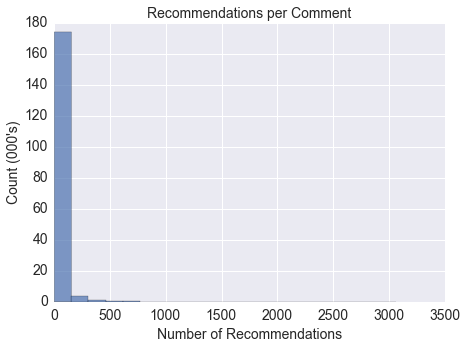

In [9]:
# Plot histogram of number of recommendations a comment receives

# Format Y axis to remove 000's
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.f' % (x*1e-3)

formatter = FuncFormatter(thousands)

# Plot
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.yaxis.set_major_formatter(formatter)
plt.hist(commentsdf["recommendationCount"],alpha = .7, bins = 20)
plt.title("Recommendations per Comment", fontsize=14)
plt.ylabel("Count (000's)", fontsize=14)
plt.xlabel("Number of Recommendations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

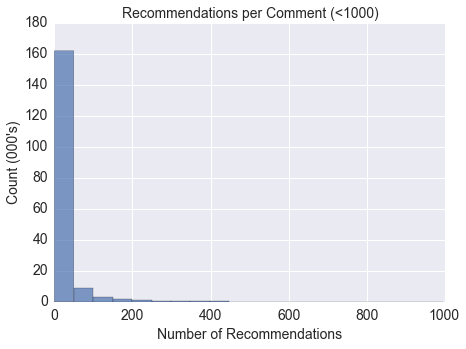

In [10]:
# Focus our histogram to recommendation counts <1000 since the above plot is not very informative
data = commentsdf[commentsdf["recommendationCount"] < 1000]

# Plot
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.yaxis.set_major_formatter(formatter)
plt.hist(data.recommendationCount,alpha = .7, bins =20)
plt.title("Recommendations per Comment (<1000)", fontsize=14)
plt.ylabel("Count (000's)", fontsize=14)
plt.xlabel("Number of Recommendations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

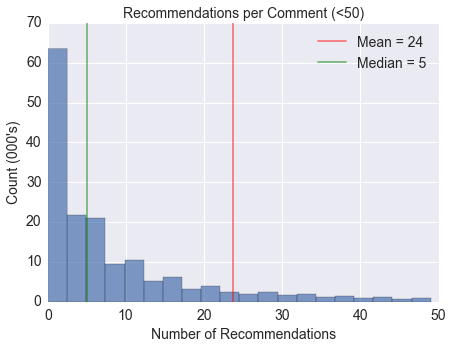

In [11]:
# Focus our histogram even more to recommendation counts <50 for best visibility into the majority of the data
data = commentsdf[commentsdf["recommendationCount"] < 50]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.yaxis.set_major_formatter(formatter)
plt.hist(data.recommendationCount, bins=20,alpha=.7)
plt.axvline(23.73,color = 'r',alpha = .5,label = 'Mean = 24')
plt.axvline(5,color = 'g',alpha = .5,label = 'Median = 5')
plt.title("Recommendations per Comment (<50)", fontsize=14)
plt.ylabel("Count (000's)", fontsize=14)
plt.xlabel("Number of Recommendations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

From these histogrames, we see that while there are some outliers on the far end of the spectrum, most of the mass is situated at <24 recommendations. 

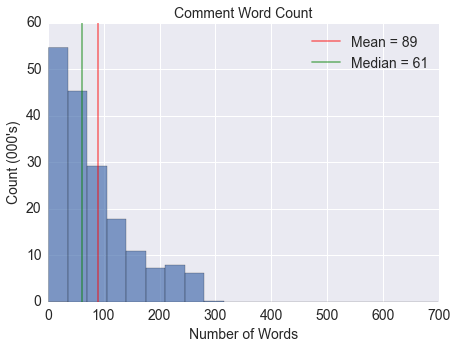

In [12]:
# Plot histogram of comment word count to get a sense of how long comments are

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.yaxis.set_major_formatter(formatter)
plt.hist(commentsdf["commentWordCount"], bins=20, alpha = .7)
plt.axvline(89,color = 'r',alpha = .5,label = 'Mean = 89')
plt.axvline(61,color = 'g',alpha = .5,label = 'Median = 61')
plt.title("Comment Word Count", fontsize=14)
plt.ylabel("Count (000's)", fontsize=14)
plt.xlabel("Number of Words", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.legend( fontsize=14)
plt.show()

From this plot, we can see that the average and median word counts are below 100. Specifically, mean work count is 81 words which equates to several sentences. 

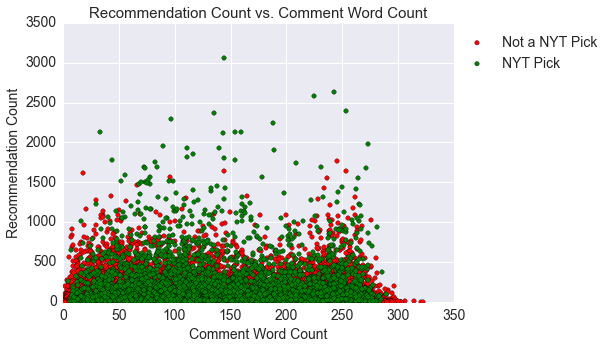

In [14]:
# Plot a Pairplot of Recommendation Count vs Comment Word Count

picks = commentsdf[commentsdf.editorsSelection ==1]
not_picks = commentsdf[commentsdf.editorsSelection == 0]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
plt.scatter(not_picks.commentWordCount,not_picks.recommendationCount, c = 'r',label = "Not a NYT Pick")
plt.scatter(picks.commentWordCount,picks.recommendationCount, c = 'g',label = "NYT Pick")

plt.xlim(0,350)
plt.ylim(0,3500)
plt.title("Recommendation Count vs. Comment Word Count", fontsize=15)
plt.ylabel("Recommendation Count", fontsize=14)
plt.xlabel("Comment Word Count", fontsize=14)
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This plot above show the similarity between NYT Picks and not NYT Picks with respect with recommendation count as well as comment word count.

### Feature Selection

We use a variety of features for our modeling:
    * Comment Word Count
    * Average Word Length in a Comment
    * Sentiment of comment 
    * Term Frequency - Inverse Document Frequency (tf-idf) 
    * Binary bag of words 

Comment word count and average word length have already been calculated earlier. They have been repasted again below as a resfresher. We feel that it is possible that comments that are longer are possibly more thorough, and thus may receive more recommendations. Similarly, perhaps comments with a longer average word length may indicate more thoughtful, better written comments.

It is also important to keep in mind that our modeling will be taking in a new comment as input. Thus, certain aspects from our data set cannot be used. For example, reply count denotes the number of replies a comment has received. A new comment will have, of course, no replies before it has been posted. Thus, we will not train our modeling using reply count as a feature.

In [15]:
word_features = commentsdf[['commentWordCount','averageWordLength']]
word_features.head()

,commentWordCount,averageWordLength
0,37,4.243243
1,69,4.811594
2,5,3.600000
3,174,4.701149
4,164,4.463415


### Sentiment analysis

We used sentiment analysis to extract a positive and negative sentiment score for every comment. We hypothesized that comment recommendations may depend on sentiment, as posts with a strong sentiment are likely to be more controversial than neutral posts.

The sentiment analysis was performed using a number of steps. Firstly, we obtained the SentiWordNet database, which is a list of English words that have been ranked for positive and negative sentiment (where their complement determines the 'neutrality' of words). After removing the file's comments, we read it into a Pandas data frame. Subsequently, we combined words that are the same into one score by taking the mean across all entries. Then we saved the sentiment per word in a dictionary, and wrote functions to calculate the average sentiment for a comment. By applying these functions to the comment bodies we obtained scores for every comment in the data frame.

In [16]:
# Read in the SentiWordNet database (without comments at the top)

sentimentdf = pd.read_csv('SentiWordNet_prepared.txt', sep='\t')  # We stripped comments and the last newline
sentimentdf.head()

,POS,ID,PosScore,NegScore,SynsetTerms,Gloss
0,a,1740,0.125,0.00,able#1,(usually followed by `to') having the necessar...
1,a,2098,0.000,0.75,unable#1,(usually followed by `to') not having the nece...
2,a,2312,0.000,0.00,dorsal#2 abaxial#1,facing away from the axis of an organ or organ...
3,a,2527,0.000,0.00,ventral#2 adaxial#1,nearest to or facing toward the axis of an org...
4,a,2730,0.000,0.00,acroscopic#1,facing or on the side toward the apex


In [17]:
# Clean up different meanings of words into one (the mean score for a word)

sentimentdf.SynsetTerms = sentimentdf.SynsetTerms.apply(lambda words: words.split(' '))
sentimentdf.SynsetTerms = sentimentdf.SynsetTerms.apply(lambda words: [word[:-2] for word in words])
sentimentdf.drop(['POS', 'ID', 'Gloss'], axis=1, inplace=True)

rebuilt = []

for row in sentimentdf.as_matrix():
    positive = row[0]
    negative = row[1]
    words = row[2]
    for word in words:
        entry = (positive, negative, word)
        rebuilt.append(entry)

sentimentdf = pd.DataFrame(rebuilt, columns=['positive', 'negative', 'word'])
sentimentdf = sentimentdf.groupby('word').agg({'positive': np.mean, 'negative': np.mean})
sentimentdf.head(4)

,positive,negative
word,,
'hood,0,0.375
's_gravenhage,0,0.000
'tween,0,0.000
'tween_decks,0,0.000


In [18]:
# Define function to calculate score per comment (avg. positive and negative scores over words)

sentiment = sentimentdf.to_dict(orient='index')
delete_characters = re.compile('\W')

def positive_score(comment):
    commentlist = comment.split(' ')
    commentlist = map(lambda s: re.sub(delete_characters, '', s).lower(), commentlist)
    score = 0.0
    number = 0
    for word in commentlist:
        if word in sentiment:
            score +=sentiment[word]['positive']
            number += 1
    if number > 0:
        return score/number
    else:
        return 0

def negative_score(comment):
    commentlist = comment.split(' ')
    commentlist = map(lambda s: re.sub(delete_characters, '', s).lower(), commentlist)
    score = 0.0
    number = 0
    for word in commentlist:
        if word in sentiment:
            score +=sentiment[word]['negative']
            number += 1
    if number > 0:
        return score/number
    else:
        return 0

In [19]:
print sentiment['exquisite']

{'positive': 0.4375, 'negative': 0.125}


#### Application to `commentsdf`

In [20]:
# Now we calculate the sentiment score for each comment

commentsdf['positive_sentiment'] = commentsdf.commentBody.apply(positive_score)
commentsdf['negative_sentiment'] = commentsdf.commentBody.apply(negative_score)
senti_commentsdf = commentsdf[['commentBody','positive_sentiment','negative_sentiment']]
senti_commentsdf.head()

,commentBody,positive_sentiment,negative_sentiment
0,"pj, I love that your reply came up 3 times. Ha...",0.068522,0.020037
1,I definitely agree that the reporter interview...,0.075430,0.033953
2,"Well said, CF. Well said.",0.125000,0.002778
3,"Who are these people who are commenting, so sm...",0.065380,0.040202
4,"To all you pain suffers, let me tell to you my...",0.053066,0.088692


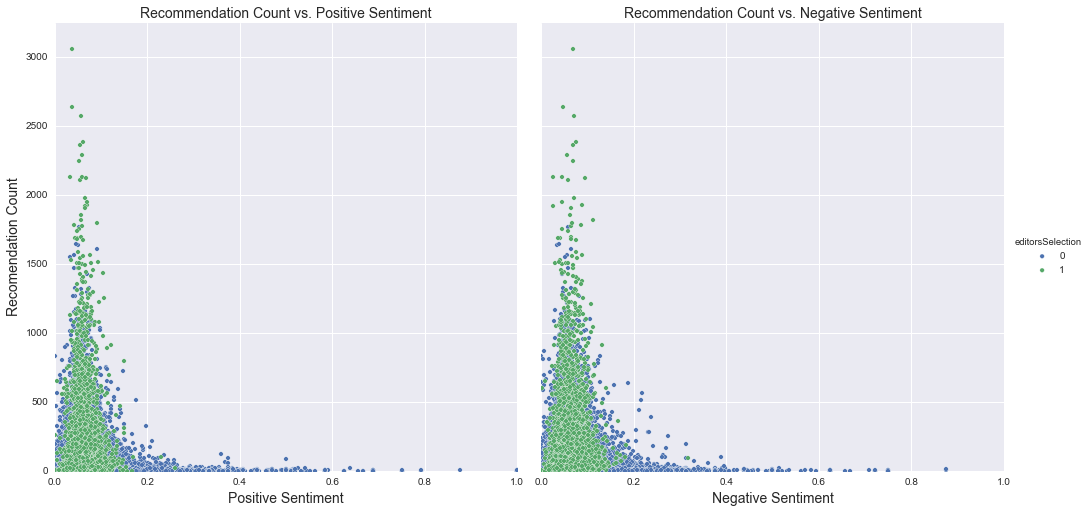

In [21]:
# Checking if the feature looks valid

pair = sns.pairplot(commentsdf, x_vars=['positive_sentiment', 'negative_sentiment'], 
                    y_vars=['recommendationCount'], hue='editorsSelection', size=7);
axes = pair.axes;
axes[0, 0].set_xlim(0, 1);
axes[0, 0].set_ylim(0, 3250);
axes[0, 1].set_xlim(0, 1);
axes[0, 1].set_ylim(0, 3250);
axes[0, 0].set_xlabel("Positive Sentiment", fontsize=14)
axes[0, 1].set_xlabel("Negative Sentiment", fontsize=14)
axes[0, 0].set_ylabel("Recomendation Count", fontsize=14)
axes[0, 0].set_title("Recommendation Count vs. Positive Sentiment", fontsize=14)
axes[0, 1].set_title("Recommendation Count vs. Negative Sentiment", fontsize=14)
plt.show()

As we can see from the above plots, most recommendations are given to posts with a 0.1 sentiment score, either positive or negative. We can also plot negative sentiment against positive sentiment to see if there is any correlation between the two. From the below plot, we see that the two features are not strongly correlated, which is good.

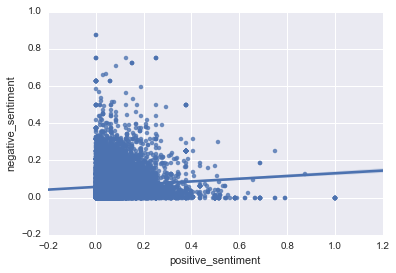

In [22]:
sns.regplot('positive_sentiment', 'negative_sentiment', data=commentsdf);

### Binary Bag of Words

We use a binary bag of words feature that encodes which of the $n$ most popular words appear in a comment. In order to determine the size of the bag, we examine how many comments have no words in the bag for various bag sizes.

In [ ]:
stop_words = text.ENGLISH_STOP_WORDS.union(['didn', 've', 'don']) # add additional stop words
corpus = commentsdf.commentBody.tolist()
word_in_bag_percent = list()

for f in np.arange(100, 301, 20):
    vectorizer = CountVectorizer(stop_words=stop_words, max_features=f, binary=True)
    bowmat = vectorizer.fit_transform(corpus) # bag of words matrix
    words = vectorizer.vocabulary_.keys()
    word_in_bag = np.zeros(commentsdf.shape[0])

    for i in range(f):
        word_in_bag = word_in_bag + bowmat[:, i].toarray().flatten()
    word_in_bag_percent.append(1. * np.sum(word_in_bag == 0) / word_in_bag.shape[0])

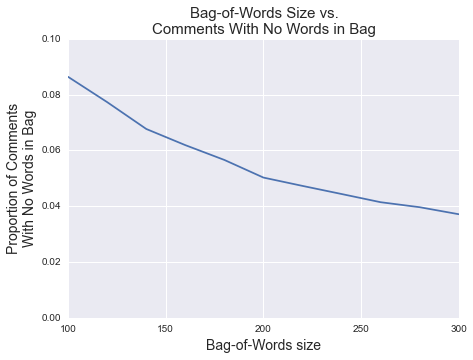

In [23]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
plt.xlim(100, 300)
plt.ylim(0, 0.1)
plt.title("Bag-of-Words Size vs.\nComments With No Words in Bag", fontsize=15)
plt.ylabel("Proportion of Comments\nWith No Words in Bag", fontsize=14)
plt.xlabel("Bag-of-Words size", fontsize=14)
plt.plot(np.arange(100, 301, 20), word_in_bag_percent);

A bag of words of size 100 is sufficient to reduce the proportion of comments with no words in the bag below 0.1. As expected, increasing the size of the bag results in diminishing returns. The choice of bag-of-words size is somewhat arbitrary, but we will use a size of 200, which results in about 95% of posts having at least one word in the bag. Heuristically, this seems to provide a reasonable balance between having informative features and having too many features.

In [23]:
stop_words = text.ENGLISH_STOP_WORDS.union(['didn', 've', 'don']) # add additional stop words
corpus = commentsdf.commentBody.tolist()
vectorizer = CountVectorizer(stop_words=stop_words, max_features=200, binary=True)
bowmat = vectorizer.fit_transform(corpus) # bag of words matrix
words = vectorizer.vocabulary_.keys()
word_in_bag = np.zeros(commentsdf.shape[0])
for i in range(200):
    commentsdf['word{}_{}'.format(i, words[i])] = bowmat[:, i].toarray().flatten()

### Tf-Idf

We add a column to the dataframe composed of the average tf-idf (term frequency-inverse document frequency) score over all words in a comment. The tf score for term $t$ in document $d$ is given by the number of times $t$ appears in $d$. The idf score for $t$ in a corpus $D$ is given by

$$\log \frac{N}{|\{d \in D: t \in d\}|}$$

where $N$ is the total number of documents, and $|\{d \in D: t \in d\}|$ is the total number of documents containing $t$. The tf-idf score for $t$ in $d$ is the $tf$ score multiplied by the $idf$ score.

Intuitively, tf-idf measures how important a word is in a document compared with how important the word is to the corpus as a whole. Words that appear frequently in documents but appear rarely in the corpus receive high scores.

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidfmat = tfidf_vectorizer.fit_transform(corpus)
commentsdf['tfidf'] = csr.sum(tfidfmat, axis=1)
commentsdf['tfidf'] = commentsdf['tfidf'].div(commentsdf['commentWordCount'], axis='index')

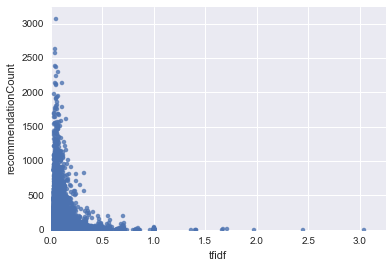

In [26]:
sns.regplot(x='tfidf', y='recommendationCount', data=commentsdf, fit_reg=False);
plt.xlim(0, 3.25);
plt.ylim(0, 3250);

## Transforming variables

We apply log and arcsinh transforms to tf-idf and sentiment scores on the basis that a very negative comment is not much different from a moderately negative comment. We also apply these transforms to the recommendation counts. As seen below, these transformations seem to do a good job transforming the "recommendation count vs. tf-idf" relationship from negative exponential to something better behaved. However, these transforms end up not being terribly effective in the end.

In [27]:
# Log transformations
commentsdf['logrecommendationCount'] = np.log(commentsdf.recommendationCount + 1)  # + 1 to deal with log(0)
commentsdf['logtfidf'] = np.log(commentsdf.tfidf)
commentsdf['logpositive'] = np.log(commentsdf.positive_sentiment)
commentsdf['lognegative'] = np.log(commentsdf.negative_sentiment)

# Arcsinh transformations
commentsdf['srecommendationCount'] = np.arcsinh(commentsdf.recommendationCount)
commentsdf['stfidf'] = np.arcsinh(commentsdf.tfidf)
commentsdf['spositive'] = np.arcsinh(commentsdf.positive_sentiment)
commentsdf['snegative'] = np.arcsinh(commentsdf.negative_sentiment)

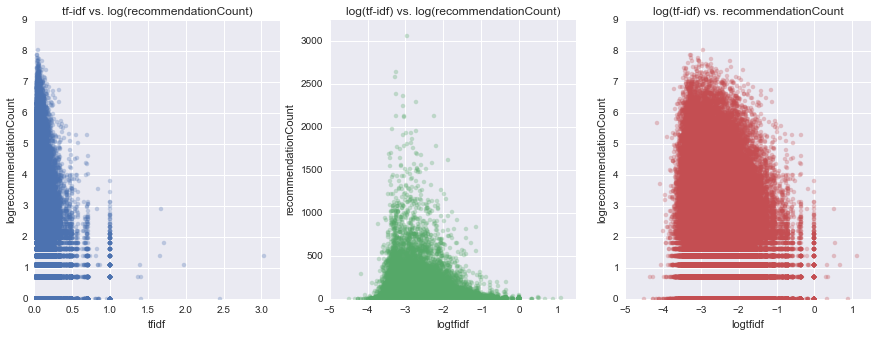

In [45]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.regplot('tfidf', 'logrecommendationCount', data=commentsdf, fit_reg=False, ax=axes[0], scatter_kws={'alpha':0.3});
sns.regplot('logtfidf', 'recommendationCount', data=commentsdf, fit_reg=False, ax=axes[1], scatter_kws={'alpha':0.3});
sns.regplot('logtfidf', 'logrecommendationCount', data=commentsdf, fit_reg=False, ax=axes[2], scatter_kws={'alpha':0.3});
axes[0].set_title('tf-idf vs. log(recommendationCount)')
axes[0].set_xlim(0, 3.25);
axes[0].set_ylim(0, 9);
axes[1].set_title('log(tf-idf) vs. log(recommendationCount)')
axes[1].set_xlim(-5, 1.5);
axes[1].set_ylim(0, 3250);
axes[2].set_title('log(tf-idf) vs. recommendationCount')
axes[2].set_xlim(-5, 1.5);
axes[2].set_ylim(0, 9);

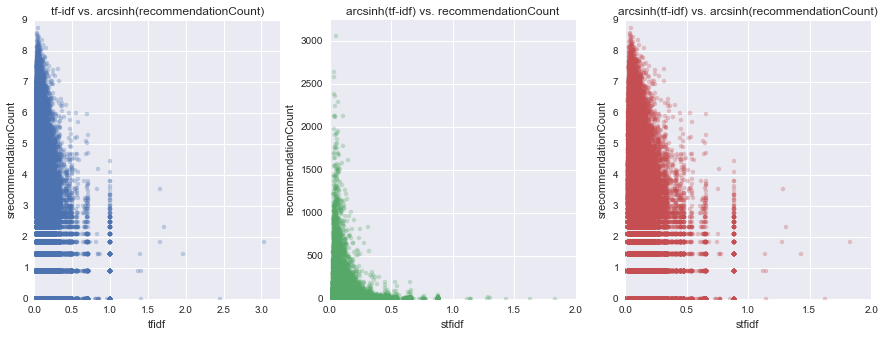

In [46]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
sns.regplot('tfidf', 'srecommendationCount', data=commentsdf, fit_reg=False, ax=axes[0], scatter_kws={'alpha':0.3});
sns.regplot('stfidf', 'recommendationCount', data=commentsdf, fit_reg=False, ax=axes[1], scatter_kws={'alpha':0.3});
sns.regplot('stfidf', 'srecommendationCount', data=commentsdf, fit_reg=False, ax=axes[2], scatter_kws={'alpha':0.3});
axes[0].set_title('tf-idf vs. arcsinh(recommendationCount)')
axes[0].set_xlim(0, 3.25);
axes[0].set_ylim(0, 9);
axes[1].set_title('arcsinh(tf-idf) vs. recommendationCount')
axes[1].set_xlim(0, 2);
axes[1].set_ylim(0, 3250);
axes[2].set_title('arcsinh(tf-idf) vs. arcsinh(recommendationCount)')
axes[2].set_xlim(0, 2);
axes[2].set_ylim(0, 9);

<a id='final'></a>
# Final Analysis

We tried a variety of methods to solve our original problem of predicting recommendation count / editor's selection. As seen below, none of them worked, so we decided instead to try to solve the somewhat easier problem of classifying comments as "good" (i.e. above a certain recommendation threshold) and "not good" (below the threshold).

In [11]:
def rmse(test, pred):
    return np.sqrt(((test - pred)**2).mean())

### Split data

Throughout, we split our data into train, validation, and test sets. We test our models on the train and validation sets, saving the test sets for when we select a final, most effective model out of the ones we try.

In [12]:
data = commentsdf.ix[:, [3] + [8] + np.arange(25, 227).tolist()].as_matrix() # select relevant columns
label = commentsdf.recommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label, test_size=0.2)
Xtrain_val, Xval, ytrain_val, yval = train_test_split(Xtrain, ytrain, test_size=0.2)

We used linear regression and a random forest regressor to predict recommendation counts.

### Linear Regression

In [73]:
regression = LinearRegression()
regression.fit(Xtrain_val, ytrain_val)
ypred = regression.predict(Xval)
print 'RMSE:', rmse(ypred, yval), '\nRMSE of predicting zero:', rmse(ypred, np.zeros_like(ypred))

RMSE: 74.4719071641 
RMSE of predicting zero: 28.6543597104


Predicting that no comment will receive any recommendations does about three times as well as linear regression.

### Random Forest Regressor

In [16]:
rf = RandomForestRegressor()
rf.fit(Xtrain_val, ytrain_val)
ypred = rf.predict(Xval)
print 'RMSE:', rmse(ypred, yval)

RMSE: 78.3484964434


Again, we do much worse than predicting zero.

Part of the reason we do badly may be because using regression to predict discrete outputs (recommendation counts can't be non-integers) is not a viable strategy. Below, we try linear regression on log(recommendation count) and arcsinh(recommendation count), but they also both fail.

###Linear Regression

In [17]:
label_log = commentsdf.logrecommendationCount.as_matrix()
Xtrain_log, Xtest_log, ytrain_log, ytest_log = train_test_split(data, label_log, test_size=0.2)
Xtrain_val_log, Xval_log, ytrain_val_log, yval_log = train_test_split(Xtrain_log, ytrain_log, test_size=0.2)

In [21]:
# Log-linear regression
regression = LinearRegression()
regression.fit(Xtrain_val_log, ytrain_val_log)
ypred = regression.predict(Xval_log)
print "RMSE:", rmse(ypred, yval_log), '\nRMSE of predicting zero:', rmse(ypred, np.zeros_like(ypred))
print 'RMSE of predicting mean:', rmse(ypred, ytrain_val_log.mean())

RMSE: 1.36409134855 
RMSE of predicting zero: 1.99152784017
RMSE of predicting mean: 0.444829046883


In [22]:
label_asin = commentsdf.logrecommendationCount.as_matrix()
Xtrain_asin, Xtest_asin, ytrain_asin, ytest_asin = train_test_split(data, label_asin, test_size=0.2)
Xtrain_val_asin, Xval_asin, ytrain_val_asin, yval_asin = train_test_split(Xtrain_asin, ytrain_asin, test_size=0.2)

In [24]:
# Arcsinh regression
regression = LinearRegression()
regression.fit(Xtrain_val_asin, ytrain_val_asin)
ypred = regression.predict(Xval_asin)
print "RMSE:", rmse(ypred, yval_asin), '\nRMSE of predicting zero:', rmse(ypred, np.zeros_like(ypred))
print 'RMSE of predicting mean:', rmse(ypred, ytrain_val_log.mean())

RMSE: 1.37001534981 
RMSE of predicting zero: 1.9992976328
RMSE of predicting mean: 0.455237807161


We are able to beat predicting zero, but predicting the mean of the training set still produces a much better result.

Next, we try logistic regression and random forest classification on editor's selection.

###  Logistic Regression & Random Forest Classifier Editor's Selection

In [15]:
label_ed = commentsdf.editorsSelection.as_matrix()
Xtrain_ed, Xtest_ed, ytrain_ed, ytest_ed = train_test_split(data, label_ed, test_size=0.2)
Xtrain_val_ed, Xval_ed, ytrain_val_ed, yval_ed = train_test_split(Xtrain_ed, ytrain_ed, test_size=0.2)

In [22]:
# Logistic regression
logreg = LogisticRegression(max_iter=100, verbose=1, n_jobs=-1)
logreg.fit(Xtrain_val_ed, ytrain_val_ed)
ypred = logreg.predict(Xval_ed)

print "Actual number of editor's choices:", np.sum(yval_ed)
print "Predicted number of editors choices:", np.sum(ypred)
print 'Confusion matrix:\n', confusion_matrix(ypred, yval_ed)

[LibLinear]Actual number of editor's choices: 799
Predicted number of editors choices: 0
Confusion matrix:
[[27945   799]
 [    0     0]]


In [24]:
# Try adjusting the threshold
def t_repredict(est, t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

print "Actual number of editor's choice",np.sum(yval_ed)
print "Predicted number of editor's choices t = 1: ", np.sum(t_repredict(logreg, .95, Xval_ed))
print "Predicted number of editor's choices t = 0.5: ", np.sum(t_repredict(logreg, 0.5, Xval_ed))
print "Predicted number of editor's choices t = 0.1: ", np.sum(t_repredict(logreg, 0.1, Xval_ed))
print "Predicted number of editor's choices t = 0.075: ", np.sum(t_repredict(logreg, 0.075, Xval_ed))
print "Predicted number of editor's choices t = 0.05: ", np.sum(t_repredict(logreg, 0.05, Xval_ed))
print "Predicted number of editor's choices t = 0.025: ", np.sum(t_repredict(logreg, 0.025, Xval_ed))

Actual number of editor's choice 799
Predicted number of editor's choices t = 1:  0
Predicted number of editor's choices t = 0.5:  0
Predicted number of editor's choices t = 0.1:  764
Predicted number of editor's choices t = 0.075:  1500
Predicted number of editor's choices t = 0.05:  3166
Predicted number of editor's choices t = 0.025:  8765


In [25]:
# We see most of the predicted positives are false positives. only 164 positive positives. 
confusion_matrix(yval_ed, t_repredict(logreg, 0.075, Xval_ed))

array([[26574,  1371],
       [  670,   129]])

In [28]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(Xtrain_val_ed, ytrain_val_ed)
ypred = rfc.predict(Xval_ed)
print confusion_matrix(ypred, yval_ed)

[[27945   798]
 [    0     1]]


The dataset is very unbalanced, so predicting that there will be no editor's selections is a viable strategy to minimize error.

### Log-Arcsinh Regression

In [54]:
# This model uses arcsinh to deal with zero values on tfidf and sentiment
data_ll = commentsdf.ix[:, [3] + [8] + range(27, 227) + range(233, 236)].as_matrix()
label_ll = commentsdf.logrecommendationCount.as_matrix()
Xtrain_ll, Xtest_ll, ytrain_ll, ytest_ll = train_test_split(data_ll, label_ll)
Xtrain_val_ll, Xval_ll, ytrain_val_ll, yval_ll = train_test_split(Xtrain_ll, ytrain_ll)

regression = LinearRegression()
regression.fit(Xtrain_val_ll, ytrain_val_ll)
ypred = regression.predict(Xval_ll)
print "RMSE:", rmse(ypred, yval_ll), 'RMSE from predicting zero:', rmse(ypred, np.zeros_like(ypred))
print 'RMSE from predicting training mean:', rmse(ypred, ytrain_val_ll.mean())

RMSE: 1.35597530849 RMSE from predicting zero: 1.999689356
RMSE from predicting training mean: 0.459776709682


It appears that the transformations of the features that we tried do not improve performance.

# Classifying Comments as "Good" and "Not Good"

As described above, predicting recommendation counts appears intractable given the data and our feature selection abilities. Therefore, we consider an easier problem: classifying comments as "good" and "not good". For our purposes, "good" comments are in the top 25% in terms of recommendations.

The problem ends up still being quite difficult and we are forced to decide which are worse: false positives or false negatives. This is a subjective decision, but in this case, we think that false positives are worse. Suppose this method was used in content recommendation system. If a good comment is not recommended, it's not a big deal, and users may still see it by scrolling down. They could also just enjoy other good recommended comments. However, if a bad comment is recommended, it would hurt the user experience. Obviously trollish comments are deleted by moderators, but a comment section full of mediocre comments could still drive readers away.

We use a linear SVC and a random forest classifier. We normalize the data before feeding it into the SVC.

In [11]:
# Helper functions
def split(rec_cutoffs, response):
    """
    Split the data according to recommendation cutoffs.
    rec_cutoffs: A vector [k1, ..., kn] of recommendation counts where the split is [k1, k2), [k2, k3), ...
        Note: kn should be greater than the largest element in response.
    """
    cat = np.zeros_like(response)
    for i in range(len(rec_cutoffs) - 1):
        cat = cat + i * np.logical_and(rec_cutoffs[i] <= response, response < rec_cutoffs[i+1])
    return cat

def getstats(conf):
    tp, fp, fn, tn = conf[0, 0], conf[0, 1], conf[1, 0], conf[1, 1]
    total = tp + fp + fn + tn
    accuracy = 1. * (tp + tn) / total
    fdr = 1. * fp / (tp + fp) # false discovery rate
    precision = 1. * tp / (tp + fp)
    recall = 1. * tp / (tp + fn)
    fnr = 1. * fn / (fp + tp)# false negative rate
    print ('accuracy: {}  false discovery rate: {}  precision: {}  recall: {}  false negative rate: {}' \
           .format(accuracy, fdr, precision, recall, fnr))

In [13]:
q = commentsdf["recommendationCount"].quantile(q=0.75)
print '75% of recommendations are below', q

75% of recommendations are below 16.0


In [14]:
# Scale the data
scale = StandardScaler()
data = commentsdf.ix[:, [3] + [8] + np.arange(25, 227).tolist()].as_matrix()
label = commentsdf.recommendationCount.as_matrix()
label_categorical = split([0, q, 9999], label)
Xtrain_cat, Xtest_cat, ytrain_cat, ytest_cat = train_test_split(data, label_categorical)
Xtrain_val_cat, Xval_cat, ytrain_val_cat, yval_cat = train_test_split(Xtrain_cat, ytrain_cat)
Xtrain_val_scaled = scale.fit_transform(Xtrain_val_cat)
Xval_scaled = scale.transform(Xval_cat)

In [97]:
# Support vector classifier
svm = LinearSVC(verbose=1, fit_intercept=False)
svm.fit(Xtrain_val_scaled, ytrain_val_cat)
ypred = svm.predict(Xval_scaled)
print confusion_matrix(yval_cat, ypred)
getstats(confusion_matrix(yval_cat, ypred))

[LibLinear][[16252  8821]
 [ 3961  4651]]
accuracy: 0.620543268517  false discovery rate: 0.351812706896  precision: 0.648187293104  recall: 0.804037005887  false negative rate: 0.15797870219


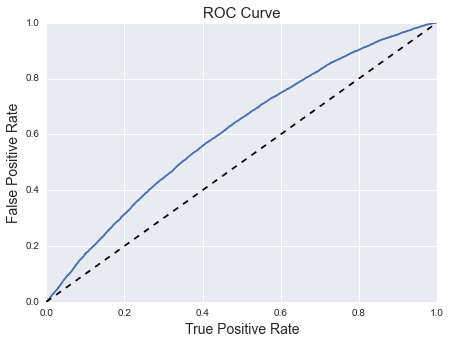

In [98]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
plt.title("ROC Curve", fontsize=15)
plt.ylabel("False Positive Rate", fontsize=14)
plt.xlabel("True Positive Rate", fontsize=14)
fpr, tpr, thresholds = roc_curve(yval_cat, svm.decision_function(Xval_cat))
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1], 'k--');

There are a great deal of false negatives and false positives here. Our false discovery rate, and false negative rate are all quite high. However, the resuls are promising.

In [77]:
# Random forest classifier
rfc = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1)
rfc.fit(Xtrain_val_cat, ytrain_val_cat)
ypred = rfc.predict(Xval_cat)
print confusion_matrix(yval_cat, ypred)
getstats(confusion_matrix(yval_cat, ypred))

[[24592   481]
 [ 8056   556]]
accuracy: 0.746563752412  false discovery rate: 0.0191839827703  precision: 0.98081601723  recall: 0.753246753247  false negative rate: 0.321301798748


(Moderate) success! The random forest classifier gives a reasonable accuracy, precision, etc. There are more false negatives than the SVC, but the false positive rate is much lower. Since we prefer false negatives to false positives, this is not too bad.

We now test the prediction on our test set and see that the results are similar to those on the validation set.

In [15]:
rfc = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1)
rfc.fit(Xtrain_cat, ytrain_cat)
ypred = rfc.predict(Xtest_cat)
print confusion_matrix(ytest_cat, ypred)
getstats(confusion_matrix(ytest_cat, ypred))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


[[32737   651]
 [10740   785]]
accuracy: 0.746376327567  false discovery rate: 0.0194980232419  precision: 0.980501976758  recall: 0.752972836212  false negative rate: 0.32167245717


<a id='conclusion'></a>
# Why Did We Have So Much Trouble, and What Could We Do Better?

We clearly had a great deal of trouble generating an even moderately useful prediction. There were two main reasons for this: (1) highly unbalanced data, and (2) the difficulty of natural language processing.

* **Unbalanced data:** As we showed in exploratory data analysis section, the vast majority of comments comments have very few recommendations, and only a small proportion of comments are designated editor's choices. This results in a dataset where predicting zero recommendations and editor's choices is effective at minimizing error. It is, in general, hard to make any sort of good predictions when the data is this unbalanced. One straightforward, but time-consuming, approach to ameliorating this problem is to get more data. This would likely be the first step in a future analysis. 180,000 comments is only a small proportion of the total comments posted each year, and collecting more data would give us more popular comments on which to train our models.

* **NLP:** NLP is a deep and complicated field, and since we did not have prior experience, we were able to perform only rudimentary feature selection. Given more time, we could research and implement more sophisticated feature selection techniques and engineer features that carry more information about the comments.

We could further improve our model by exploring how an article relates to its comments. As a simple example, positive sentiment sentiment comments on restaurant reviews might fare better than positive comments on highly politicized editorials, but the true relationships are likely much more intricate. With a larger sample of comments and article data, we could use a deep learning approach to derive insights from the complicated relationships between articles and comments, and between comments and other comments. Building a model that incorporates article text and metadata could be very powerful; unfortunately, it would also require much more data scraping and much more sophisticated methods, both of which are time-prohibitive.